In [1]:
import os
import sys
import csv
import ast
import torch
import itertools

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import Counter
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import NullFormatter

sys.path.insert(0, '/home/darryl/dev/LTFF/toy_model_interpretability')
from model_helper import *

In [2]:
# Reconstruct the model
def model_builder(N, m, k, nonlinearity):
    if nonlinearity == 'ReLU':
        activation = nn.ReLU()
    elif nonlinearity == 'GeLU':
        activation = nn.GELU()
    elif nonlinearity == 'SoLU':
        activation = lambda x: x*torch.exp(x)    
    
    model = torch.nn.Sequential(
                nn.Linear(m, k, bias=True),
                activation,
                nn.Linear(k, N, bias=False)
            )
    return model

In [3]:
def loss_func(batch_size, outputs, vectors):
    loss = np.sum((outputs - vectors)**2) / batch_size
    return loss

In [4]:
def sample_vectors_equal(N: int, eps: float, batch_size: int, embedder):
    """
        Generates random uniform vectors in a tensor of shape (N,batch_size)
        with sparsity 1-eps. These are returned as v.

        Applies embedding matrix to v to produce a low-dimensional embedding,
        returned as x.
    """

    v = torch.rand((int(batch_size), int(N)))
    
    compare = eps * torch.ones((int(batch_size), int(N)))
    sparsity = torch.bernoulli(compare)
            
    v *= sparsity
    x = torch.matmul(v,embedder.T) # Embeds features in a low-dimensional space

    return v, x

In [5]:
def get_mono_neuron_output(mono_d, neurons, feature, ins):
    result = 0
    for neuron in neurons:
        x = np.dot(mono_d['0.weight'][neuron], ins[feature]) + np.array(mono_d['0.bias'][neuron])
        print(x, x.shape)
        x = np.dot(np.maximum(np.array(0), x), mono_d['2.weight'].T)
        result += x[feature]
    return result

In [6]:
# model = 'model3'
model='soft_dot_penalised_model'
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = 0.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.0
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
# lr = 0.001
lrs = [0.001,0.003,0.005,0.007,0.01,0.03]

In [7]:
print(lrs)

# Load and process data
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in lrs
])
ReLU_equal_lr_sweep = []
for n in names:
    try:
        ReLU_equal_lr_sweep.append(torch.load(n, map_location=torch.device('cpu')))
    except FileNotFoundError:
        print(n,'not found')

[0.001, 0.003, 0.005, 0.007, 0.01, 0.03]


In [44]:
batch = ReLU_equal_lr_sweep[0] # lr = 0.001
fixed_embedder = batch['setup']['fixed_embedder']
d = batch['log2_spaced_models'][-1]

model_ = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], batch['nonlinearity'])
model_.load_state_dict(batch['log2_spaced_models'][-1])
model_.to('cpu')

sfa = single_feature_activations(d, batch, batch['setup'])
unit_sfa = np.array(sfa > 0.0, dtype='int')

where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]
mono_d = deepcopy(batch['log2_spaced_models'][-1])
mono_d['0.weight'][where_poly, :] *= 0
mono_d['0.bias'][where_poly] *= 0
mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                           d['0.weight'].shape[0], batch['nonlinearity'])
mono_model.load_state_dict(mono_d)
mono_model.to('cpu')

# pls.append(loss_func(N, model.forward(ins).detach().numpy(), vs.detach().numpy()))
# pmls.append(loss_func(N, mono_model.forward(ins).detach().numpy(), vs.detach().numpy()))

Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=False)
)

In [45]:
vs = torch.eye(N)
ins = torch.matmul(vs, fixed_embedder.T)

In [46]:
sfa = model_[:2].forward(ins).T.detach().numpy()

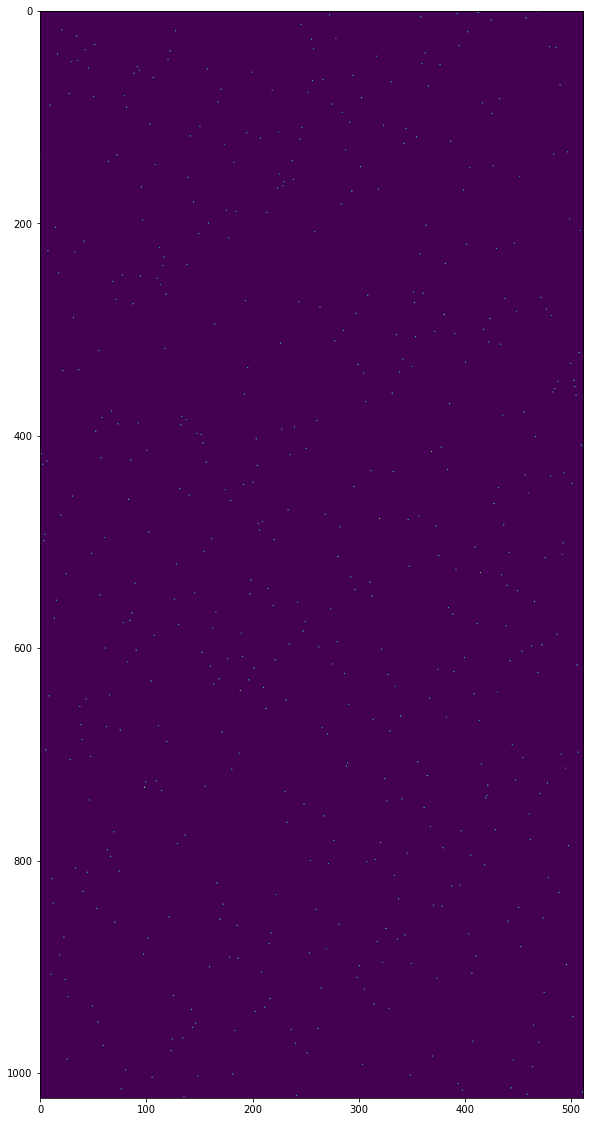

In [47]:
plt.figure(figsize=(20,20))
plt.imshow(sfa)
plt.show()

In [48]:
# Sort the neurons to put the most-monosemantic first
inds = np.argsort(-np.amax(sfa,axis=1) / (1e-10 + np.mean(sfa,axis=1)))
sfa = sfa[inds]

# Sort the features to put the most-monosemantic neurons first
neuron_inds = []
for i in range(sfa.shape[1]): # Loop over features
    neuron_ind = np.argmax(sfa[:,i]) # Find the neuron this feature activates most-strongly.
    neuron_inds.append(neuron_ind)
inds = np.argsort(neuron_inds) # Sort the neuron indices
sfa = sfa[:,inds]

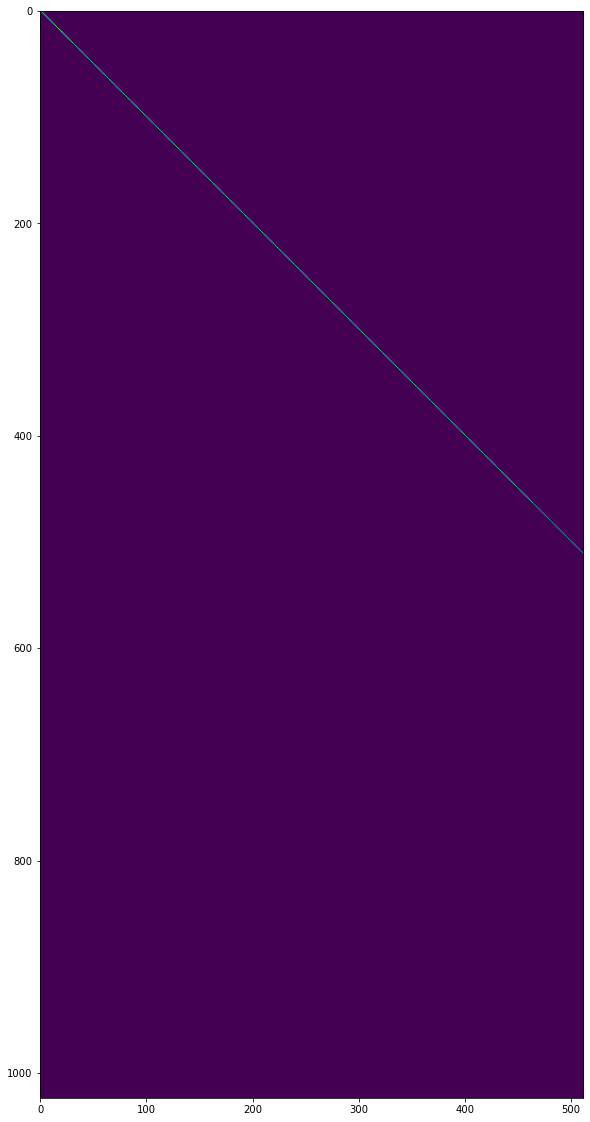

In [51]:
plt.figure(figsize=(20,20))
plt.imshow(sfa)
plt.show()

In [76]:
vs = torch.ones(N, N) - torch.eye(N)
ins = torch.matmul(vs, fixed_embedder.T)

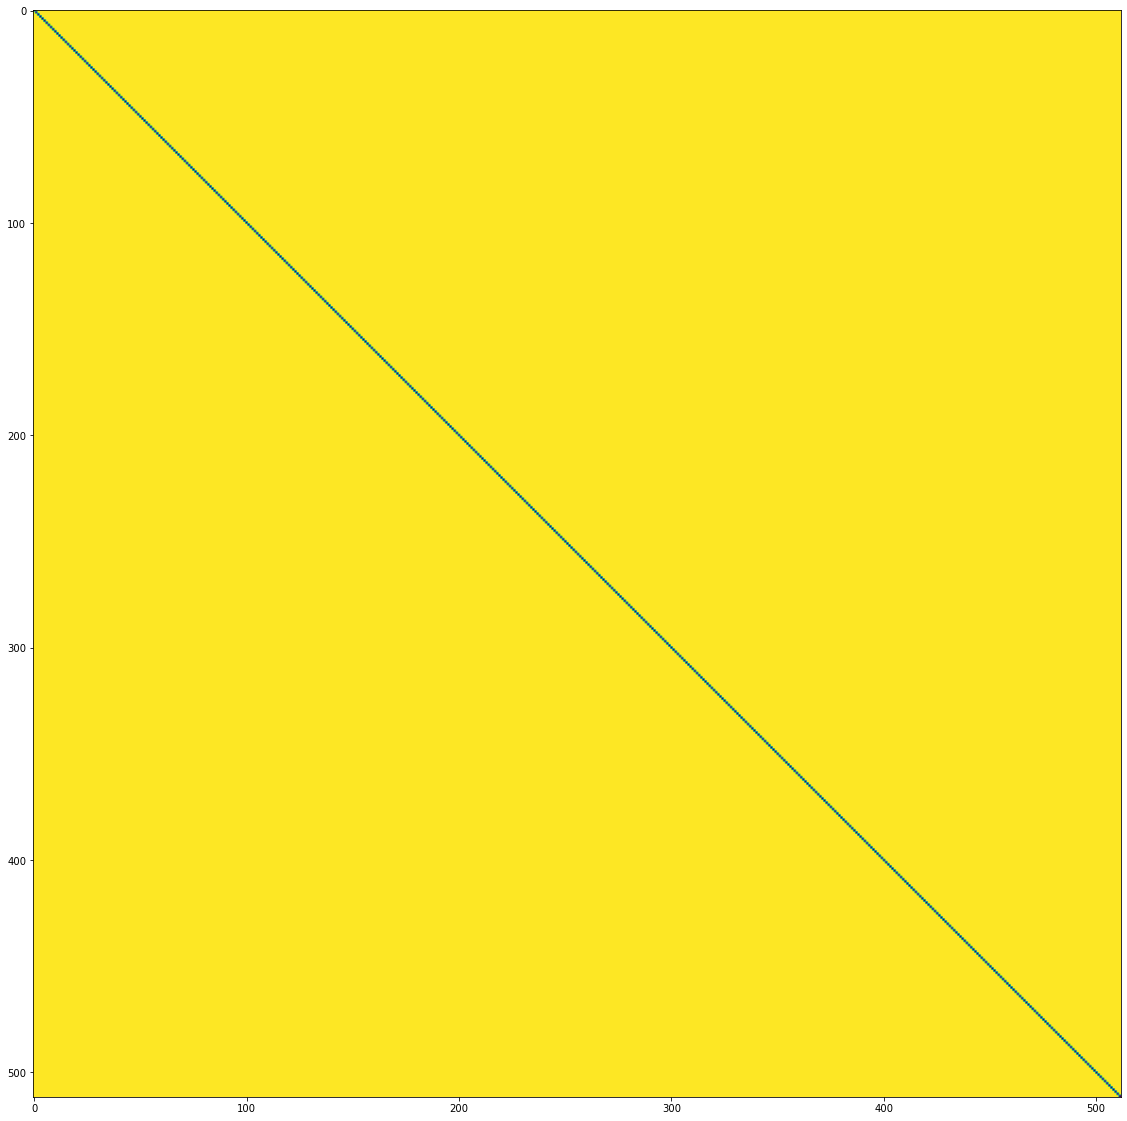

In [77]:
plt.figure(figsize=(20,20))
plt.imshow(vs.detach().numpy())
plt.show()

In [78]:
outputs = model_[:2].forward(ins).T.detach().numpy()

In [79]:
print(np.min(outputs[:10], axis=1))

[0.       0.       0.       0.       0.       6.742456 0.       0.
 6.577348 0.      ]


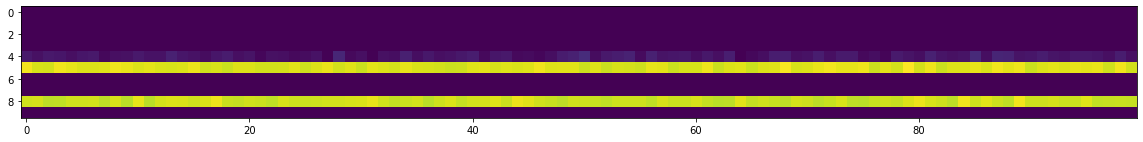

In [81]:
plt.figure(figsize=(20,20))
plt.imshow(np.array(outputs)[:10,:100])
plt.show()

In [ ]:
lr = 0.001
path = f'../my_plots/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}/learning_rate_{lr}/'
with open(os.path.join(path, 'features_to_neurons_report.csv'), 'r') as infile:
    reader = csv.DictReader(infile)
    for row in reader:
#         print(type(row['activating_neurons']))
        print(get_mono_neuron_output(mono_d, [int(n) for n in ast.literal_eval(row['activating_neurons'])], int(row['feature_id']), ins))
        break